In [111]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

IMG_SIZE = 28
NUM_CHANNELS = 1
LATENT_SPACE_SIZE = 100

In [112]:
# plot image
def plot_image(epoch, generator, samples=16):
    noise = np.random.normal(0, 1, (samples, LATENT_SPACE_SIZE))
    images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [IMG_SIZE, IMG_SIZE])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [113]:
# build generator
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_shape=(LATENT_SPACE_SIZE,), activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(IMG_SIZE * IMG_SIZE * NUM_CHANNELS, activation='tanh'))
    model.add(Reshape((IMG_SIZE, IMG_SIZE, NUM_CHANNELS)))
    
    return model

In [114]:
# build discriminator
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS)))
    model.add(Dense((IMG_SIZE * IMG_SIZE * NUM_CHANNELS), activation='relu'))
    model.add(Dense((IMG_SIZE * IMG_SIZE * NUM_CHANNELS // 2), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [115]:
# build stacked generator / discriminator
def build_stacked(generator, discriminator):
    
    # disable training on discriminator
    for layer in discriminator.layers:
        layer.trainable = False
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    return model

In [116]:
# train the model
def train_model(stacked, generator, discriminator, X_train, num_epochs=20000, batch_size=32, save_interval=500):
    print("Training...")
    for epoch in range(num_epochs):
        
        # train discriminator
        random_index = np.random.randint(0, len(X_train) - batch_size//2)
        legit_images = X_train[random_index : random_index + batch_size//2].reshape(batch_size//2, IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
        gen_noise = np.random.normal(0, 1, (batch_size//2, LATENT_SPACE_SIZE))
        fake_images = generator.predict(gen_noise)
        
        X_combined_batch = np.concatenate((legit_images, fake_images))
        y_combined_batch = np.concatenate((np.ones((batch_size//2, 1)), np.zeros((batch_size//2, 1))))
        d_loss = discriminator.train_on_batch(X_combined_batch, y_combined_batch)

        # train generator
        noise = np.random.normal(0, 1, (batch_size, LATENT_SPACE_SIZE))
        y_mislabeled = np.ones((batch_size, 1))
        g_loss = stacked.train_on_batch(noise, y_mislabeled)

        if epoch % save_interval == 0:
            print("Epoch: " + str(epoch) + ", Discriminator: " + str(d_loss) + ", Generator: " + str(g_loss))
            plot_image(epoch, generator)

Training...


/home/jesse/.local/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0, Discriminator: 0.71437395, Generator: 0.6896415


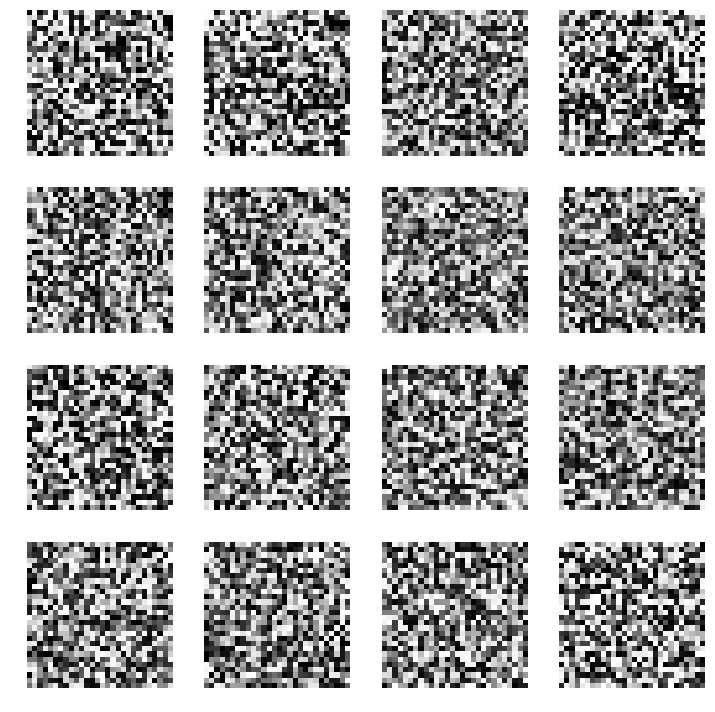

Epoch: 500, Discriminator: 0.27252793, Generator: 3.3153224


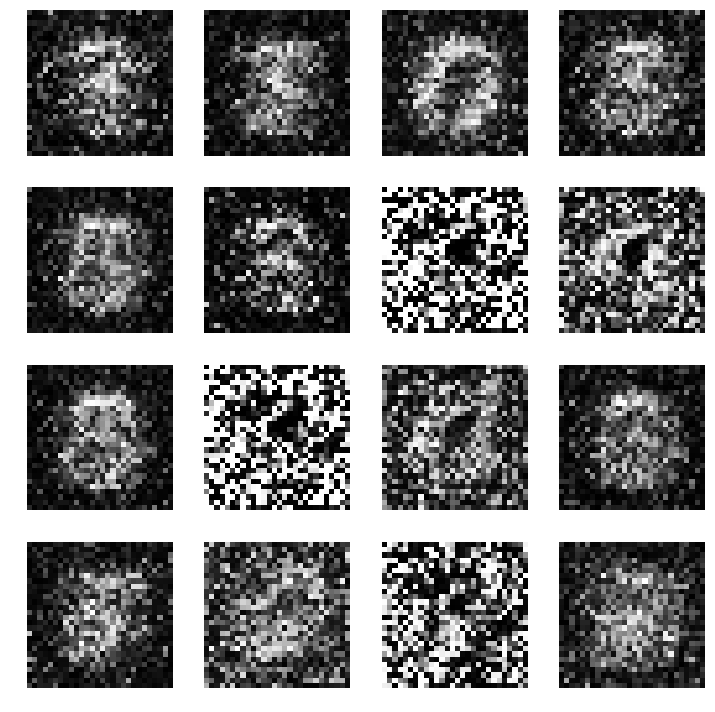

Epoch: 1000, Discriminator: 0.70699614, Generator: 0.6074741


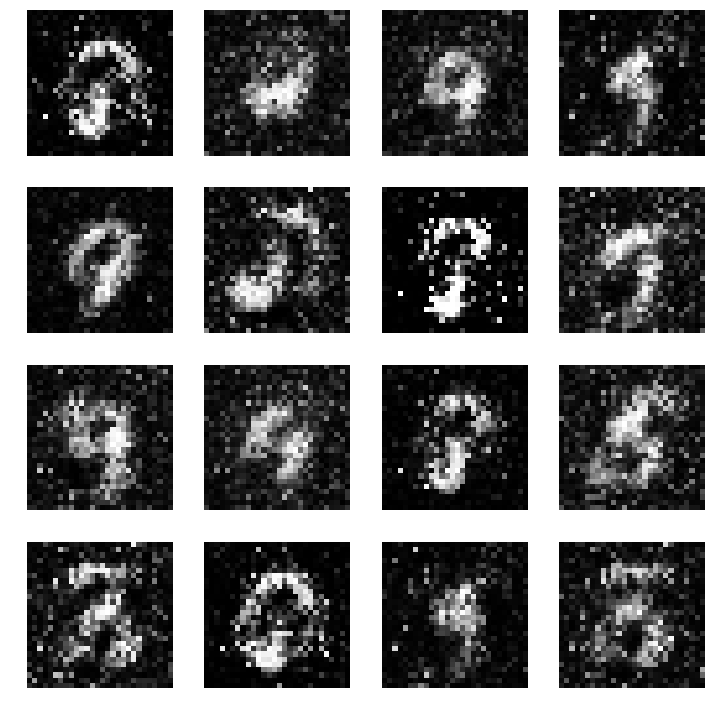

Epoch: 1500, Discriminator: 0.67020875, Generator: 0.8822962


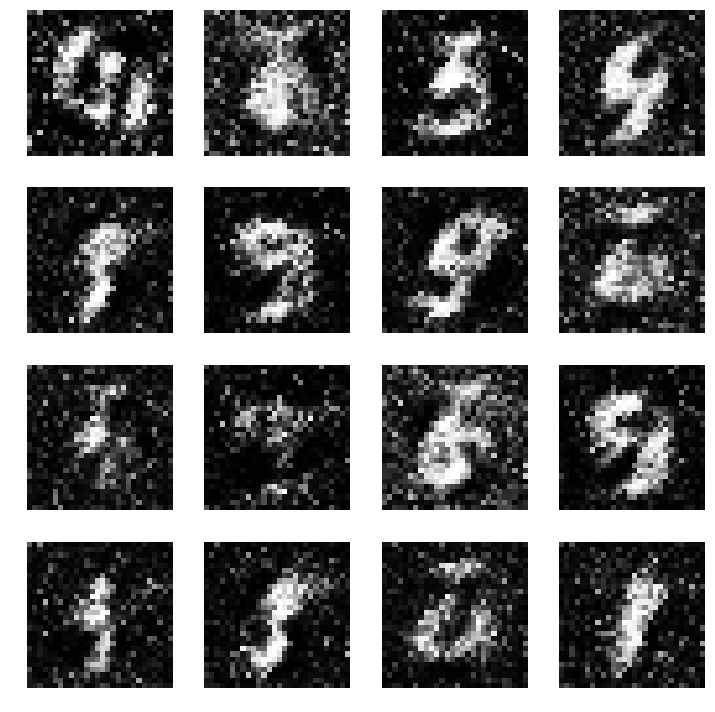

Epoch: 2000, Discriminator: 0.55268955, Generator: 1.0848284


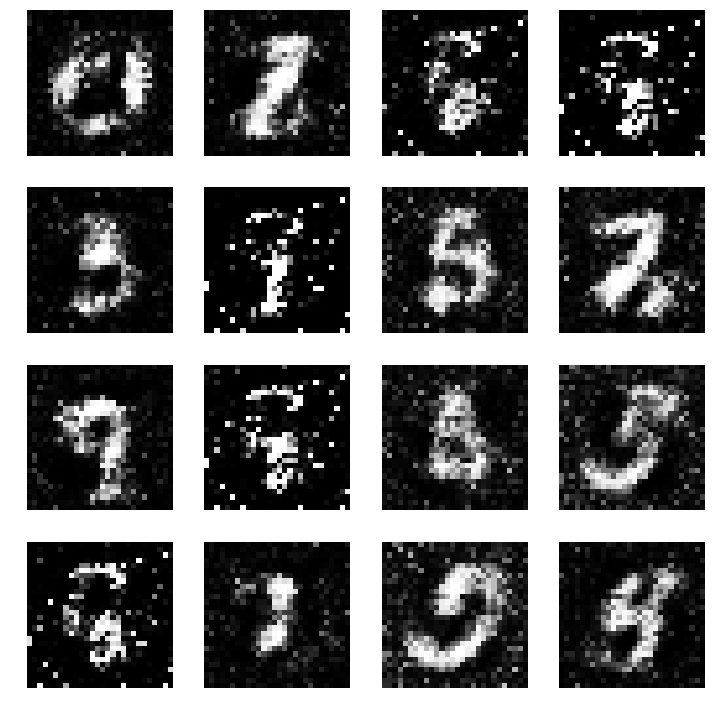

Epoch: 2500, Discriminator: 0.8897924, Generator: 0.7048588


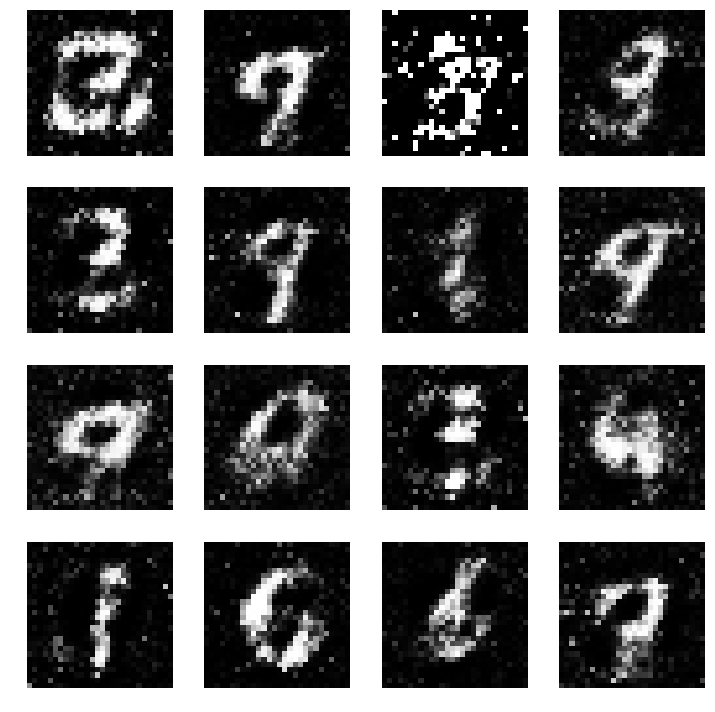

Epoch: 3000, Discriminator: 0.5924052, Generator: 1.046674


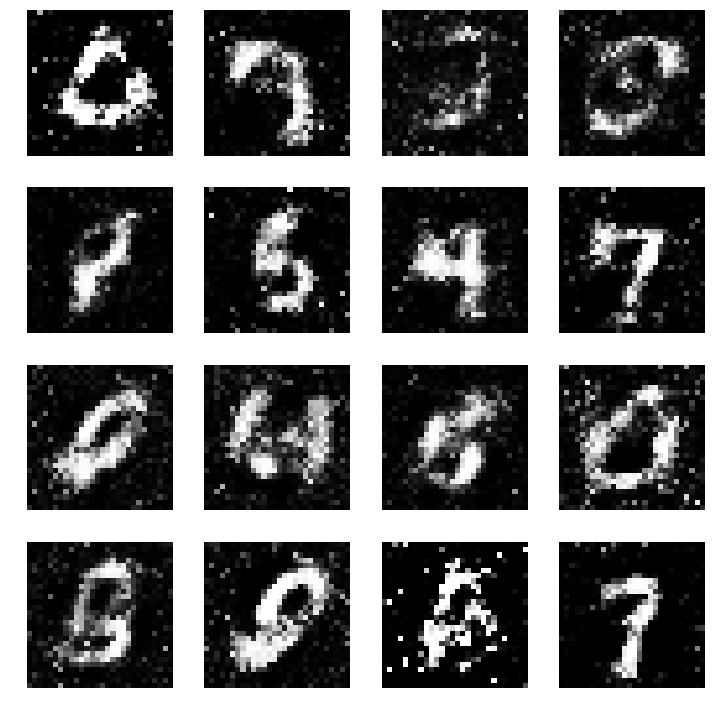

Epoch: 3500, Discriminator: 0.5590392, Generator: 1.0226331


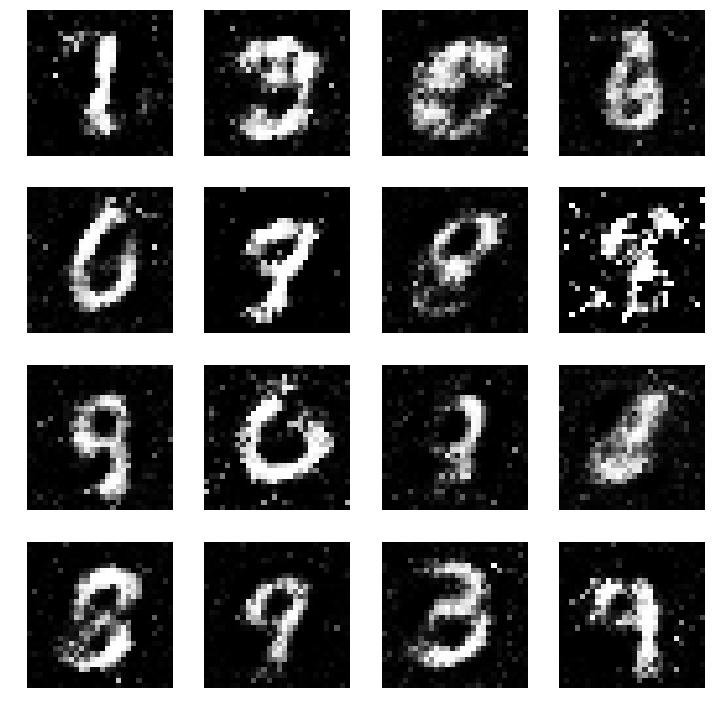

Epoch: 4000, Discriminator: 0.5665914, Generator: 1.171493


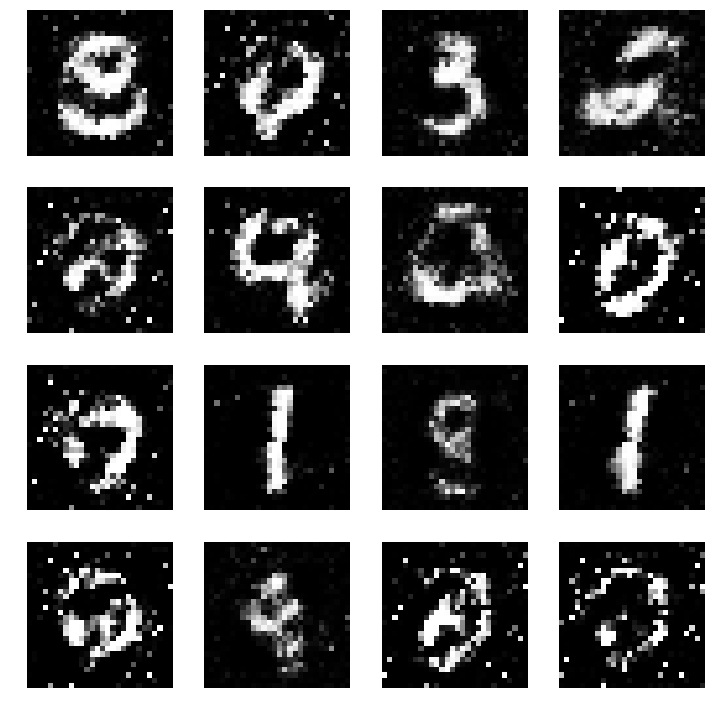

Epoch: 4500, Discriminator: 0.54545695, Generator: 0.8707262


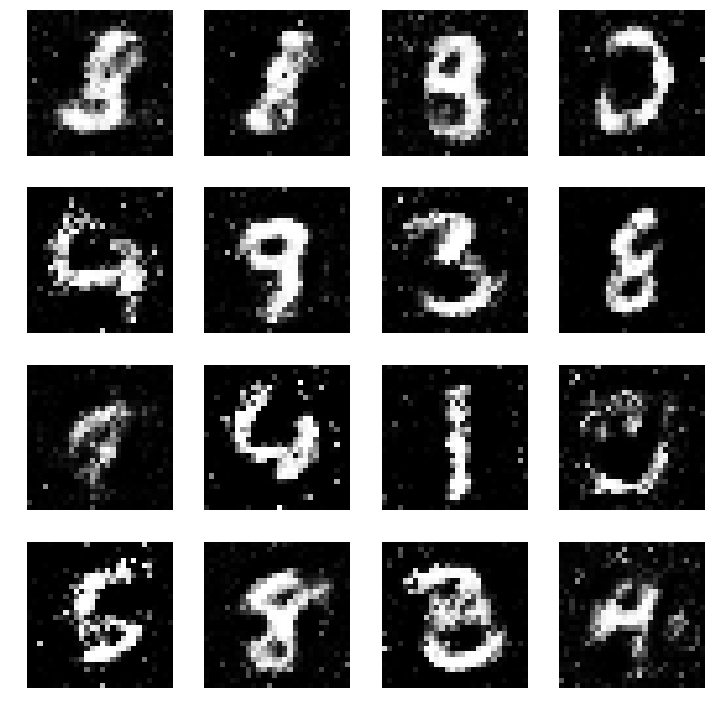

Epoch: 5000, Discriminator: 0.63575506, Generator: 0.8430273


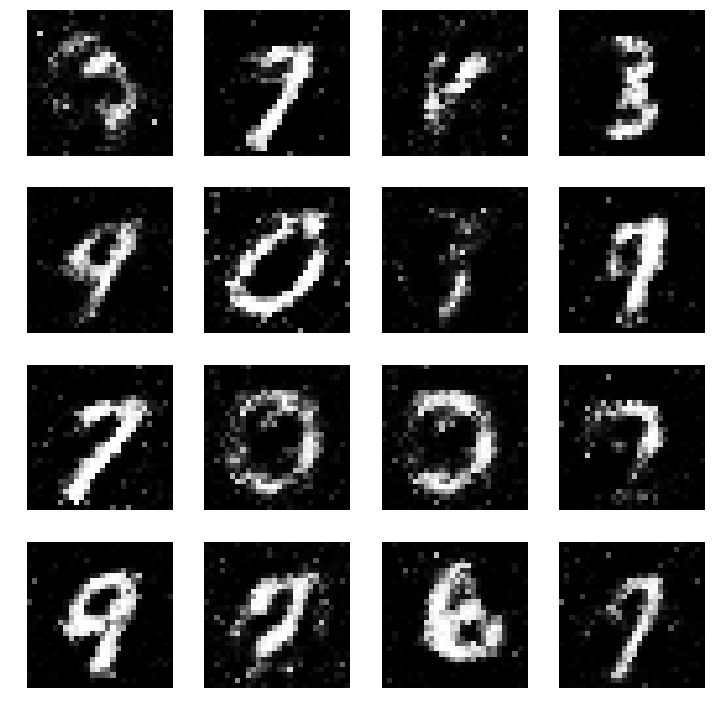

Epoch: 5500, Discriminator: 0.57104826, Generator: 0.883109


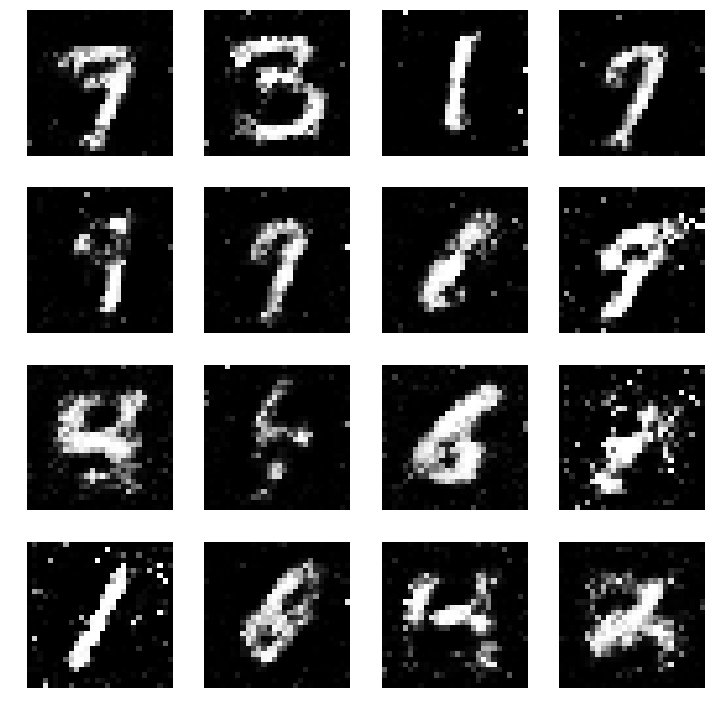

Epoch: 6000, Discriminator: 0.69567746, Generator: 0.76918954


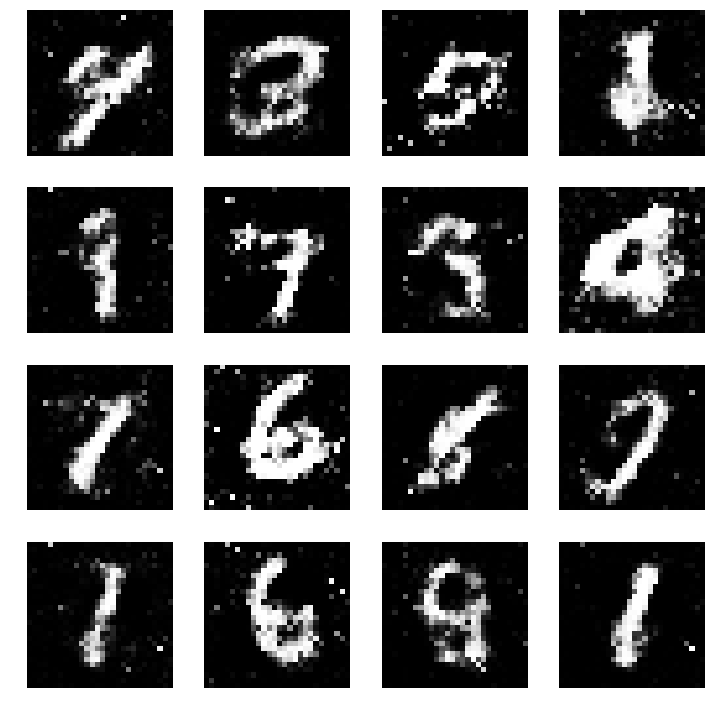

In [ ]:
# load the MNIST data
(X_train, _), (_,_) = mnist.load_data()

# rescale -1 to 1
X_train = (X_train - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

generator = build_generator()
#generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, decay=8e-8))

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, decay=8e-8))

stacked = build_stacked(generator, discriminator)
stacked.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, decay=8e-8))

# train the model
train_model(stacked, generator, discriminator, X_train)